In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from collections import Counter, defaultdict

In [2]:
allowed_ext = ('.jpeg', '.jpg', '.bmp', '.png')
path = 'Data'
IMG_SIZE = 224

images = []
labels = []

try:
    classes = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    print(f"Classes trouvées: {classes}")
    
    for class_name in classes:
        class_path = os.path.join(path, class_name)
        image_files = os.listdir(class_path)
        
        for img_file in image_files:
            if img_file.lower().endswith(allowed_ext):
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path)
                
                if img is not None:
                    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    images.append(img_resized)
                    labels.append(class_name)
            else:
                os.remove(os.path.join(class_path, img_file))
                
except Exception as e:
    print(f"Erreur: {e}")

Classes trouvées: ['meningioma', 'glioma', 'notumor', 'pituitary']


In [3]:
images, labels = shuffle(images, labels, random_state=42)

In [4]:
images = np.array(images)
labels = np.array(labels)
print(f"Shape des images: {images.shape}")
print(f"Shape des labels: {labels.shape}")

Shape des images: (7023, 224, 224, 3)
Shape des labels: (7023,)


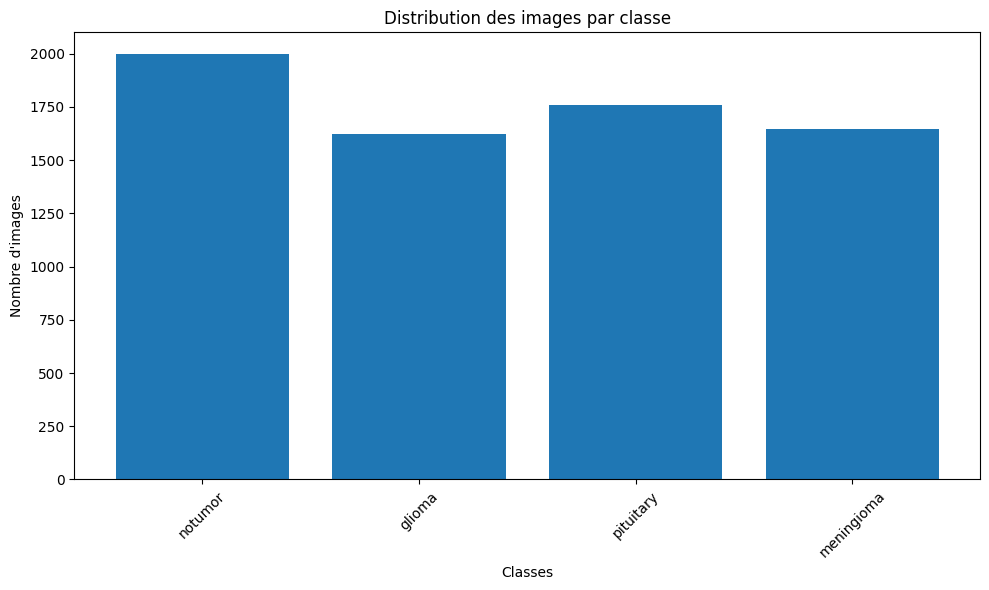

notumor: 2000 images
glioma: 1621 images
pituitary: 1757 images
meningioma: 1645 images


In [5]:
class_counts = Counter(labels)
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Distribution des images par classe')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

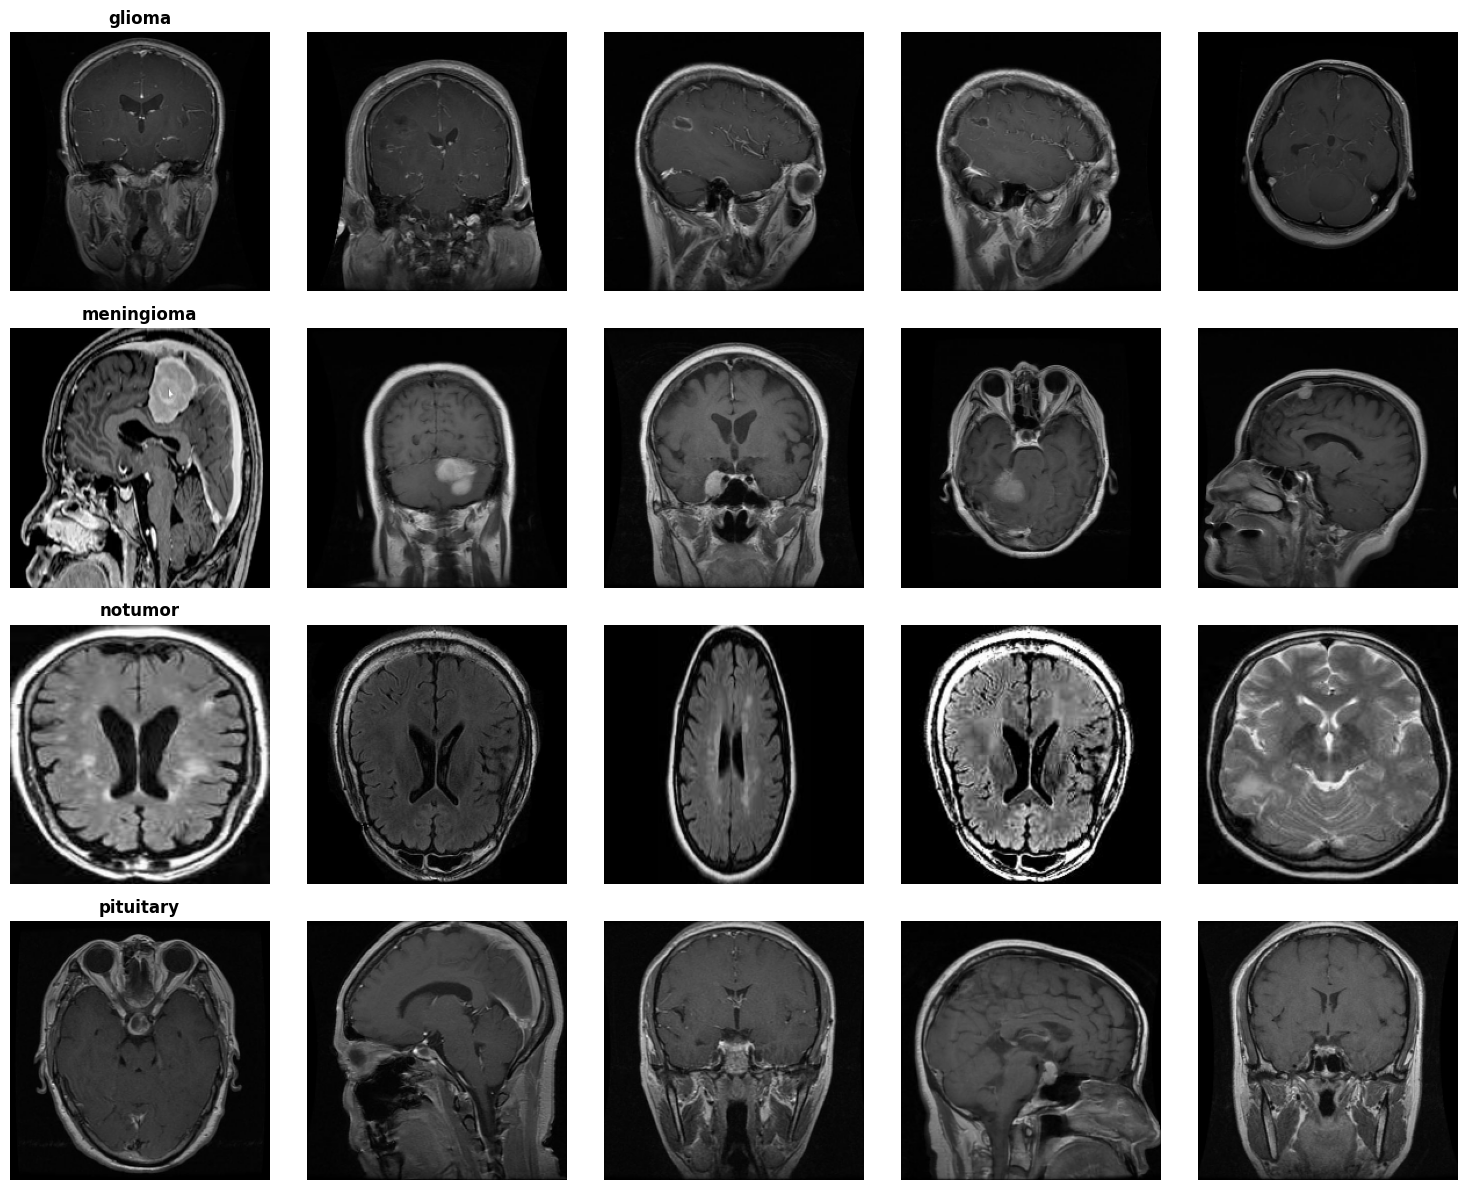

In [6]:
unique_classes = np.unique(labels)
fig, axes = plt.subplots(len(unique_classes), 5, figsize=(15, len(unique_classes) * 3))

for i, class_name in enumerate(unique_classes):
    class_indices = np.where(labels == class_name)[0][:5]
    
    for j, idx in enumerate(class_indices):
        ax = axes[i, j] if len(unique_classes) > 1 else axes[j]
        img_rgb = cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.axis('off')
        if j == 0:
            ax.set_title(f'{class_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [7]:
from sklearn.utils import resample

min_samples = min(class_counts.values())
max_samples = max(class_counts.values())
ratio = max_samples / min_samples

print(f"Déséquilibre: ratio max/min = {ratio:.2f}")

if ratio > 1.5:
    print("Rééquilibrage nécessaire")
    
    balanced_images = []
    balanced_labels = []
    
    for class_name in unique_classes:
        class_indices = np.where(labels == class_name)[0]
        class_images = images[class_indices]
        class_labels = labels[class_indices]
        
        resampled_images, resampled_labels = resample(
            class_images, class_labels, 
            n_samples=max_samples, 
            random_state=42
        )
        
        balanced_images.append(resampled_images)
        balanced_labels.append(resampled_labels)
    
    images = np.vstack(balanced_images)
    labels = np.concatenate(balanced_labels)
    
    images, labels = shuffle(images, labels, random_state=42)
    
    print(f"Nouvelle shape des images: {images.shape}")
    print(f"Nouvelle distribution: {Counter(labels)}")
else:
    print("Classes équilibrées")

Déséquilibre: ratio max/min = 1.23
Classes équilibrées


In [8]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

print(f"Classes originales: {le.classes_}")
print(f"Encodage: {dict(zip(le.classes_, range(len(le.classes_))))}")
print(f"Shape des labels encodés: {labels_encoded.shape}")

Classes originales: ['glioma' 'meningioma' 'notumor' 'pituitary']
Encodage: {np.str_('glioma'): 0, np.str_('meningioma'): 1, np.str_('notumor'): 2, np.str_('pituitary'): 3}
Shape des labels encodés: (7023,)


In [9]:
from tensorflow.keras.utils import to_categorical

labels_categorical = to_categorical(labels_encoded)
print(f"Shape des labels catégoriels: {labels_categorical.shape}")
print(f"Exemple de label encodé: {labels_categorical[0]}")

2025-10-15 10:16:41.278421: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 10:16:41.306309: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shape des labels catégoriels: (7023, 4)
Exemple de label encodé: [0. 0. 1. 0.]


2025-10-15 10:16:42.172268: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    zoom_range=0.1,
    brightness_range=[0.8, 1.2], 
    fill_mode='nearest'
)

images_par_classe = defaultdict(list)
for i, label in enumerate(labels):
    img = images[i] / 255.0
    if len(img.shape) == 2: 
        img = np.expand_dims(img, -1)
    images_par_classe[label].append(img)

max_count = 2000
output_dir = "Data_Balanced"
os.makedirs(output_dir, exist_ok=True)

for label, imgs in images_par_classe.items():
    print(f"→ Classe {label} en cours")
    class_dir = os.path.join(output_dir, str(label))
    os.makedirs(class_dir, exist_ok=True)

    current = imgs.copy()
    while len(current) < max_count:
        current.append(datagen.random_transform(random.choice(imgs)))

    for i, img in enumerate(current[:max_count]):
        img = np.clip(img * 255, 0, 255).astype(np.uint8)
        if img.shape[-1] == 1: 
            img = img.squeeze(-1)
        cv2.imwrite(os.path.join(class_dir, f"{label}_{i:04d}.jpg"), img)

print(f"Rééquilibrage terminé et sauvegardé dans : {output_dir}")